In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score

from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier,Pool
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.ensemble import RUSBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,roc_curve
from imblearn.over_sampling import SMOTE, ADASYN,RandomOverSampler
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN,SMOTETomek
import optuna
import mlflow
import pickle
import os


### Funciones

In [2]:
def calidad_none(df):
    # Reemplazar 'None' (cadena) con NaN
    df_replaced = df.replace('None', np.nan)
    
    # Contar valores nulos (NaN) en cada columna
    none_counts = df_replaced.isna().sum()
    
    # Crear un DataFrame con los resultados
    result = pd.DataFrame({'Column': none_counts.index, 
                           'None_Count': none_counts.values,
                           'None_Percentage': none_counts.values / len(df) })
    
    return result

# Construcción de Base de Modelado

## Base a Modelar

In [3]:
df_op_base_pivot_var_rpta = pd.read_csv('df_op_base_pivot_var_rpta_v2.csv')
df_var_prob_mod_cobranza = pd.read_csv('df_var_prob_mod_cobranza_v2.csv')
df_master_customer = pd.read_csv('df_master_customer_v2.csv')
df_comportamieto_pagos = pd.read_csv(r'C:\Users\davzapat\Documents\Personal\Reto  Kaggle\df_comportamiento_pagos_v2.csv')

In [4]:
df_op_base_pivot_var_rpta = df_op_base_pivot_var_rpta.sort_values(by='fecha_var_rpta_alt')

In [5]:
df_op_base_pivot_var_rpta.head()

,llave_modelo,llave_modelo_2,fecha_var_rpta_alt,var_rpta_alt,tipo_var_rpta_alt,min_mora,max_mora,dias_mora_fin,vlr_vencido,saldo_capital,...,tiene_libranza,tiene_rot,tiene_otros_productos,ranking_plan_pago,ranking_acepta_alternativa,ranking_no_acepta_acuerdo,ranking_plan_compromiso_cumplido,ranking_int_alternativa,ranking_otros,fecha_corte
0,630611#219718#863073,630611#219718,202308,1,a_uno_tipo_1,46,71,71,1000259.0,5808115.68,...,0,0,0,0,1,0,0,0,0,202307
105583,336661#793364#286978,336661#793364,202308,1,a_uno_tipo_1,3,33,33,1958434.0,14803622.95,...,0,0,0,0,1,0,0,0,0,202307
105582,613599#192664#895581,613599#192664,202308,1,a_uno_tipo_1,5,11,0,69774.0,873665.10,...,0,0,0,0,1,0,0,0,0,202307
105580,367161#631647#448695,367161#631647,202308,1,a_uno_tipo_1,21,44,44,1120047.0,14766113.79,...,0,0,0,0,1,0,0,0,0,202307
105579,460669#553850#526492,460669#553850,202308,1,b_uno_tipo_2,18,24,0,31462.0,860572.00,...,0,1,0,0,1,0,0,0,0,202307


In [6]:
# Obtener el conteo de valores
value_counts = df_op_base_pivot_var_rpta['fecha_var_rpta_alt'].value_counts()

# Convertir el resultado a un DataFrame
value_counts_df = value_counts.reset_index()
value_counts_df.columns = ['fecha_var_rpta_alt', 'count']

# Ordenar el DataFrame por la columna de fechas
value_counts_df = value_counts_df.sort_values(by='fecha_var_rpta_alt')

# Mostrar el DataFrame ordenado
print(value_counts_df)

   fecha_var_rpta_alt  count
2              202308  47274
0              202309  51962
3              202310  44654
1              202311  49645
4              202312  40467


In [7]:
df_op_base_pivot_var_rpta_v1 = df_op_base_pivot_var_rpta.drop(columns=['tipo_var_rpta_alt'])
df_op_base_pivot_var_rpta_v1['llave_modelo3'] = df_op_base_pivot_var_rpta_v1['llave_modelo'].apply(lambda x: f"{x.split('#')[0]}#{x.split('#')[-1]}")
df_op_base_pivot_var_rpta_v1.head()

,llave_modelo,llave_modelo_2,fecha_var_rpta_alt,var_rpta_alt,min_mora,max_mora,dias_mora_fin,vlr_vencido,saldo_capital,endeudamiento,...,tiene_rot,tiene_otros_productos,ranking_plan_pago,ranking_acepta_alternativa,ranking_no_acepta_acuerdo,ranking_plan_compromiso_cumplido,ranking_int_alternativa,ranking_otros,fecha_corte,llave_modelo3
0,630611#219718#863073,630611#219718,202308,1,46,71,71,1000259.0,5808115.68,12134572.0,...,0,0,0,1,0,0,0,0,202307,630611#863073
105583,336661#793364#286978,336661#793364,202308,1,3,33,33,1958434.0,14803622.95,27174818.0,...,0,0,0,1,0,0,0,0,202307,336661#286978
105582,613599#192664#895581,613599#192664,202308,1,5,11,0,69774.0,873665.10,37250585.0,...,0,0,0,1,0,0,0,0,202307,613599#895581
105580,367161#631647#448695,367161#631647,202308,1,21,44,44,1120047.0,14766113.79,16345511.0,...,0,0,0,1,0,0,0,0,202307,367161#448695
105579,460669#553850#526492,460669#553850,202308,1,18,24,0,31462.0,860572.00,23972267.0,...,1,0,0,1,0,0,0,0,202307,460669#526492


In [8]:
df_op_base_pivot_var_rpta_v2 = df_op_base_pivot_var_rpta_v1[[
    'llave_modelo',
    'llave_modelo_2',
    'llave_modelo3',
    'fecha_corte',
    'var_rpta_alt'
]]

prob_cobranza

In [9]:
df_var_prob_mod_cobranza=df_var_prob_mod_cobranza.fillna(0)
df_var_prob_mod_cobranza.head()

,nit_enmascarado,num_oblig_enmascarado,fecha_corte,lote,prob_propension,prob_alrt_temprana,prob_auto_cura,llave_modelo_2,fecha_corte_format,lote_n-1,...,prob_alrt_temprana_n-4,prob_auto_cura_n-4,lote_n-5,prob_propension_n-5,prob_alrt_temprana_n-5,prob_auto_cura_n-5,lote_n-6,prob_propension_n-6,prob_alrt_temprana_n-6,prob_auto_cura_n-6
0,556678,533754,202307,2,0.873170,0.635381,0.493065,556678#533754,2023-07-01,2.0,...,0.544476,0.640089,2.0,0.875894,0.510321,0.663543,2.0,0.931532,0.304766,0.853967
1,501276,255081,202307,1,0.958621,0.089577,0.876630,501276#255081,2023-07-01,1.0,...,0.047321,0.856946,1.0,0.957645,0.039800,0.870228,1.0,0.957748,0.043846,0.874493
2,193108,943635,202307,2,0.830457,0.294235,0.886318,193108#943635,2023-07-01,2.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
3,93496,364086,202307,1,0.217236,0.681259,0.241066,93496#364086,2023-07-01,1.0,...,0.469305,0.441671,1.0,0.811721,0.528716,0.465230,1.0,0.813898,0.165370,0.747743
4,222088,246313,202307,1,0.940583,0.066140,0.744681,222088#246313,2023-07-01,1.0,...,0.064876,0.734329,1.0,0.916859,0.068737,0.691577,1.0,0.887322,0.083305,0.681657


In [10]:
df_var_prob_mod_cobranza_v1 = df_var_prob_mod_cobranza[[
    'llave_modelo_2'
    , 'fecha_corte'
    , 'lote'
    , 'prob_propension'
    , 'prob_alrt_temprana'
    , 'prob_auto_cura'
    , 'lote_n-1'
    , 'prob_propension_n-1'
    , 'prob_alrt_temprana_n-1'
    , 'prob_auto_cura_n-1'
    , 'lote_n-2'
    , 'prob_propension_n-2'
    , 'prob_alrt_temprana_n-2'
    , 'prob_auto_cura_n-2'
    , 'lote_n-3'
    , 'prob_propension_n-3'
    , 'prob_alrt_temprana_n-3'
    , 'prob_auto_cura_n-3'
    , 'lote_n-4'
    , 'prob_propension_n-4'
    , 'prob_alrt_temprana_n-4'
    , 'prob_auto_cura_n-4'
    , 'lote_n-5'
    , 'prob_propension_n-5'
    , 'prob_alrt_temprana_n-5'
    , 'prob_auto_cura_n-5'
    , 'lote_n-6'
    , 'prob_propension_n-6'
    , 'prob_alrt_temprana_n-6'
    , 'prob_auto_cura_n-6'
    
]]

In [158]:
df_var_prob_mod_cobranza_v1.head()

,llave_modelo_2,fecha_corte,lote,prob_propension,prob_alrt_temprana,prob_auto_cura,lote_n-1,prob_propension_n-1,prob_alrt_temprana_n-1,prob_auto_cura_n-1,lote_n-2,prob_propension_n-2,prob_alrt_temprana_n-2,prob_auto_cura_n-2,lote_n-3,prob_propension_n-3,prob_alrt_temprana_n-3,prob_auto_cura_n-3,lote_n-4,prob_propension_n-4,prob_alrt_temprana_n-4,prob_auto_cura_n-4,lote_n-5,prob_propension_n-5,prob_alrt_temprana_n-5,prob_auto_cura_n-5,lote_n-6,prob_propension_n-6,prob_alrt_temprana_n-6,prob_auto_cura_n-6
0,556678#533754,202307,2,0.873170,0.635381,0.493065,2.0,0.831257,0.607044,0.540089,2.0,0.795900,0.515509,0.427108,2.0,0.828909,0.592756,0.494731,2.0,0.861027,0.544476,0.640089,2.0,0.875894,0.510321,0.663543,2.0,0.931532,0.304766,0.853967
1,501276#255081,202307,1,0.958621,0.089577,0.876630,1.0,0.957019,0.065718,0.877039,1.0,0.958096,0.062776,0.886100,1.0,0.952028,0.055786,0.872772,1.0,0.957342,0.047321,0.856946,1.0,0.957645,0.039800,0.870228,1.0,0.957748,0.043846,0.874493
2,193108#943635,202307,2,0.830457,0.294235,0.886318,2.0,0.830608,0.316500,0.890659,2.0,0.802868,0.334608,0.849232,2.0,0.786731,0.085007,0.772945,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
3,93496#364086,202307,1,0.217236,0.681259,0.241066,1.0,0.317335,0.677990,0.294602,1.0,0.539214,0.678889,0.279609,1.0,0.756014,0.649579,0.321246,1.0,0.820721,0.469305,0.441671,1.0,0.811721,0.528716,0.465230,1.0,0.813898,0.165370,0.747743
4,222088#246313,202307,1,0.940583,0.066140,0.744681,1.0,0.935897,0.063058,0.764890,1.0,0.937776,0.076439,0.689288,1.0,0.940101,0.073863,0.704433,1.0,0.937075,0.064876,0.734329,1.0,0.916859,0.068737,0.691577,1.0,0.887322,0.083305,0.681657


In [11]:
merged_df_v1= pd.merge(df_op_base_pivot_var_rpta_v2, 
                     df_var_prob_mod_cobranza_v1, 
                     left_on=['llave_modelo3', 'fecha_corte'], 
                     right_on=['llave_modelo_2', 'fecha_corte'], 
                     how='left')  # tipos 'left', 'right' o 'outer' 

merged_df_v1.head()

,llave_modelo,llave_modelo_2_x,llave_modelo3,fecha_corte,var_rpta_alt,llave_modelo_2_y,lote,prob_propension,prob_alrt_temprana,prob_auto_cura,...,prob_alrt_temprana_n-4,prob_auto_cura_n-4,lote_n-5,prob_propension_n-5,prob_alrt_temprana_n-5,prob_auto_cura_n-5,lote_n-6,prob_propension_n-6,prob_alrt_temprana_n-6,prob_auto_cura_n-6
0,630611#219718#863073,630611#219718,630611#863073,202307,1,630611#863073,1.0,0.654196,0.487352,0.227337,...,0.473203,0.379341,1.0,0.835031,0.266729,0.810193,1.0,0.835059,0.204160,0.825482
1,336661#793364#286978,336661#793364,336661#286978,202307,1,336661#286978,1.0,0.798003,0.560215,0.292046,...,0.643775,0.451835,1.0,0.907931,0.517799,0.624980,1.0,0.942597,0.374518,0.881658
2,613599#192664#895581,613599#192664,613599#895581,202307,1,613599#895581,2.0,0.837624,0.363493,0.677305,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
3,367161#631647#448695,367161#631647,367161#448695,202307,1,367161#448695,1.0,0.903988,0.724407,0.265100,...,0.375370,0.691871,1.0,0.930693,0.180338,0.850191,1.0,0.938062,0.208156,0.848339
4,460669#553850#526492,460669#553850,460669#526492,202307,1,460669#526492,2.0,0.913819,0.167954,0.868063,...,0.084654,0.795844,2.0,0.928916,0.075912,0.809298,2.0,0.912777,0.083173,0.805748


In [160]:
merged_df_v1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 234002 entries, 0 to 234001
Data columns (total 34 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   llave_modelo            234002 non-null  object 
 1   llave_modelo_2_x        234002 non-null  object 
 2   llave_modelo3           234002 non-null  object 
 3   fecha_corte             234002 non-null  int64  
 4   var_rpta_alt            234002 non-null  int64  
 5   llave_modelo_2_y        233524 non-null  object 
 6   lote                    233524 non-null  float64
 7   prob_propension         233524 non-null  float64
 8   prob_alrt_temprana      233524 non-null  float64
 9   prob_auto_cura          233524 non-null  float64
 10  lote_n-1                233524 non-null  float64
 11  prob_propension_n-1     233524 non-null  float64
 12  prob_alrt_temprana_n-1  233524 non-null  float64
 13  prob_auto_cura_n-1      233524 non-null  float64
 14  lote_n-2            

In [12]:
merged_df_v1['nit_enmascarado'] = merged_df_v1['llave_modelo'].apply(lambda x: x.split('#')[0])

In [13]:
merged_df_v1['nit_enmascarado']=merged_df_v1['nit_enmascarado'].astype(str)

Master Customer

In [163]:
df_master_customer.head()

,nit_enmascarado,edad_cli,num_hijos,personas_dependientes,declarante,total_ing,tot_activos,tot_pasivos,egresos_mes,tot_patrimonio,year,month,es_cliente,es_cliente_social,es_excliente,es_soltero,es_casado,es_union_libre,vivienda_familiar,vivienda_propia,vivienda_alquilada,acad_universitario,acad_bachiller,acad_tecnologo,acad_primaria,acad_especializacion,fecha_corte
0,536377,25.0,0.0,0.0,0,2607680.0,33750000.0,0.0,0.0,33750000.0,2023,12,1,0,0,1,0,0,1,0,0,1,0,0,0,0,202312
1,512257,38.0,0.0,0.0,0,1000000.0,5000000.0,0.0,250000.0,5000000.0,2023,9,1,0,0,0,0,1,0,1,0,0,0,1,0,0,202309
2,5788,63.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,2023,11,0,1,0,0,0,0,0,0,0,0,0,0,0,0,202311
3,132245,41.0,1.0,0.0,0,1800000.0,62513000.0,0.0,1000000.0,62513000.0,2023,7,1,0,0,0,1,0,0,0,0,0,0,1,0,0,202307
4,245279,43.0,0.0,1.0,0,2500000.0,45135000.0,11000000.0,1000000.0,34135000.0,2023,12,1,0,0,0,1,0,0,0,1,0,0,0,0,0,202312


In [164]:
df_master_customer['nit_enmascarado']=df_master_customer['nit_enmascarado'].astype(str)

In [166]:
merged_df_v2= pd.merge(merged_df_v1, 
                     df_master_customer, 
                     left_on=['nit_enmascarado', 'fecha_corte'], 
                     right_on=['nit_enmascarado', 'fecha_corte'], 
                     how='left')  # Puedes cambiar el tipo de unión a 'left', 'right' o 'outer' si es necesario

# Mostrar las primeras filas del DataFrame resultante
merged_df_v2.head()

,llave_modelo,llave_modelo_2_x,llave_modelo3,fecha_corte,var_rpta_alt,llave_modelo_2_y,lote,prob_propension,prob_alrt_temprana,prob_auto_cura,lote_n-1,prob_propension_n-1,prob_alrt_temprana_n-1,prob_auto_cura_n-1,lote_n-2,prob_propension_n-2,prob_alrt_temprana_n-2,prob_auto_cura_n-2,lote_n-3,prob_propension_n-3,prob_alrt_temprana_n-3,prob_auto_cura_n-3,lote_n-4,prob_propension_n-4,prob_alrt_temprana_n-4,prob_auto_cura_n-4,lote_n-5,prob_propension_n-5,prob_alrt_temprana_n-5,prob_auto_cura_n-5,lote_n-6,prob_propension_n-6,prob_alrt_temprana_n-6,prob_auto_cura_n-6,nit_enmascarado,edad_cli,num_hijos,personas_dependientes,declarante,total_ing,tot_activos,tot_pasivos,egresos_mes,tot_patrimonio,year,month,es_cliente,es_cliente_social,es_excliente,es_soltero,es_casado,es_union_libre,vivienda_familiar,vivienda_propia,vivienda_alquilada,acad_universitario,acad_bachiller,acad_tecnologo,acad_primaria,acad_especializacion
0,630611#219718#863073,630611#219718,630611#863073,202307,1,630611#863073,1.0,0.654196,0.487352,0.227337,1.0,0.611498,0.433004,0.441248,1.0,0.551677,0.503961,0.495446,1.0,0.510642,0.475989,0.388084,1.0,0.714727,0.473203,0.379341,1.0,0.835031,0.266729,0.810193,1.0,0.835059,0.204160,0.825482,630611,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,336661#793364#286978,336661#793364,336661#286978,202307,1,336661#286978,1.0,0.798003,0.560215,0.292046,1.0,0.841778,0.714580,0.164356,1.0,0.881070,0.666959,0.292288,1.0,0.921015,0.546696,0.520405,1.0,0.915755,0.643775,0.451835,1.0,0.907931,0.517799,0.624980,1.0,0.942597,0.374518,0.881658,336661,23.0,0.0,0.0,0.0,2447320.0,1743830.0,0.0,50000.0,1743830.0,2023.0,7.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,613599#192664#895581,613599#192664,613599#895581,202307,1,613599#895581,2.0,0.837624,0.363493,0.677305,3.0,0.808138,0.193679,0.694363,3.0,0.831383,0.074353,0.780137,3.0,0.843415,0.068410,0.790509,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,613599,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,367161#631647#448695,367161#631647,367161#448695,202307,1,367161#448695,1.0,0.903988,0.724407,0.265100,1.0,0.888850,0.653495,0.327682,1.0,0.880482,0.615750,0.368090,1.0,0.890559,0.580151,0.399465,1.0,0.898768,0.375370,0.691871,1.0,0.930693,0.180338,0.850191,1.0,0.938062,0.208156,0.848339,367161,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,460669#553850#526492,460669#553850,460669#526492,202307,1,460669#526492,2.0,0.913819,0.167954,0.868063,2.0,0.922986,0.080959,0.870252,2.0,0.928275,0.079100,0.835316,2.0,0.922964,0.073847,0.812644,2.0,0.913990,0.084654,0.795844,2.0,0.928916,0.075912,0.809298,2.0,0.912777,0.083173,0.805748,460669,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [167]:
merged_df_v2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 234002 entries, 0 to 234001
Data columns (total 60 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   llave_modelo            234002 non-null  object 
 1   llave_modelo_2_x        234002 non-null  object 
 2   llave_modelo3           234002 non-null  object 
 3   fecha_corte             234002 non-null  int64  
 4   var_rpta_alt            234002 non-null  int64  
 5   llave_modelo_2_y        233524 non-null  object 
 6   lote                    233524 non-null  float64
 7   prob_propension         233524 non-null  float64
 8   prob_alrt_temprana      233524 non-null  float64
 9   prob_auto_cura          233524 non-null  float64
 10  lote_n-1                233524 non-null  float64
 11  prob_propension_n-1     233524 non-null  float64
 12  prob_alrt_temprana_n-1  233524 non-null  float64
 13  prob_auto_cura_n-1      233524 non-null  float64
 14  lote_n-2            

No se usra datos de la master dado que son que se encuentran alta cantidad de nulos luego de realizar el left join


comportamieto_pagos

In [168]:
df_comportamieto_pagos.head()

,llave_modelo_2,fecha_corte,valor_cuota_mes,pago_total,porc_pago,tiene_cuota_tdc,tiene_cuota_libr_inv,tiene_cuota_rot,tiene_cuota_cart_ordinaria,tiene_cuota_hipo,tiene_cuota_libranza,diferencia_dias,marca_pago_mas,marca_pago_menos,marca_pago_igual,marca_no_pago,marca_facturacion_mes_sgte,marca_cancelado,marca_ajustes_banco,ajustes_banco_no,ajustes_banco_rediferidos,ajustes_banco_ajustes,valor_cuota_mes_n-1,pago_total_n-1,porc_pago_n-1,diferencia_dias_n-1,valor_cuota_mes_n-2,pago_total_n-2,porc_pago_n-2,diferencia_dias_n-2,valor_cuota_mes_n-3,pago_total_n-3,porc_pago_n-3,diferencia_dias_n-3,valor_cuota_mes_n-4,pago_total_n-4,porc_pago_n-4,diferencia_dias_n-4,valor_cuota_mes_n-5,pago_total_n-5,porc_pago_n-5,diferencia_dias_n-5,valor_cuota_mes_n-6,pago_total_n-6,porc_pago_n-6,diferencia_dias_n-6
0,66222#939332,202307,167699.0,499650.0,298.0,1,0,0,0,0,0,9.0,1,0,0,0,0,0,0,1,0,0,113186.0,156000.0,138.0,0.0,128227.0,0.0,0.0,0.0,258956.0,835467.0,323.0,14.0,155496.0,0.0,0.0,0.0,247722.0,743754.0,300.0,0.0,369556.0,793506.0,215.0,7.0
1,346534#894271,202307,11389.0,0.0,0.0,1,0,0,0,0,0,0.0,0,0,0,1,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,467770#414119,202307,1083867.0,0.0,0.0,0,1,0,0,0,0,0.0,0,0,0,1,0,0,0,1,0,0,1068451.0,0.0,0.0,0.0,1076875.0,2156459.0,200.0,17.0,1068891.0,1069000.0,100.0,0.0,1068351.0,1070268.0,100.0,22.0,530756.0,1592268.0,300.0,0.0,530756.0,1592268.0,300.0,0.0
3,321249#799652,202307,140537.0,281074.0,200.0,1,0,0,0,0,0,0.0,1,0,0,0,0,0,0,1,0,0,94429.0,188859.0,200.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,96560#694989,202307,628950.0,1257900.0,200.0,1,0,0,0,0,0,1.0,1,0,0,0,0,0,0,1,0,0,593895.0,1187792.0,200.0,0.0,111051.0,222102.0,200.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
merged_df_v2= pd.merge(merged_df_v1, 
                     df_comportamieto_pagos, 
                     left_on=['llave_modelo3', 'fecha_corte'], 
                     right_on=['llave_modelo_2', 'fecha_corte'], 
                     how='left') 
merged_df_v2.head()

,llave_modelo,llave_modelo_2_x,llave_modelo3,fecha_corte,var_rpta_alt,llave_modelo_2_y,lote,prob_propension,prob_alrt_temprana,prob_auto_cura,...,porc_pago_n-4,diferencia_dias_n-4,valor_cuota_mes_n-5,pago_total_n-5,porc_pago_n-5,diferencia_dias_n-5,valor_cuota_mes_n-6,pago_total_n-6,porc_pago_n-6,diferencia_dias_n-6
0,630611#219718#863073,630611#219718,630611#863073,202307,1,630611#863073,1.0,0.654196,0.487352,0.227337,...,0.0,0.0,496815.0,0.0,0.0,0.0,538113.0,1614342.0,300.0,0.0
1,336661#793364#286978,336661#793364,336661#286978,202307,1,336661#286978,1.0,0.798003,0.560215,0.292046,...,665.0,12.0,970803.0,11367391.0,1171.0,13.0,970803.0,4896428.0,504.0,29.0
2,613599#192664#895581,613599#192664,613599#895581,202307,1,613599#895581,2.0,0.837624,0.363493,0.677305,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,367161#631647#448695,367161#631647,367161#448695,202307,1,367161#448695,1.0,0.903988,0.724407,0.265100,...,300.0,24.0,556445.0,1114706.0,200.0,0.0,556931.0,2226752.0,400.0,28.0
4,460669#553850#526492,460669#553850,460669#526492,202307,1,460669#526492,2.0,0.913819,0.167954,0.868063,...,200.0,0.0,31317.0,125268.0,400.0,21.0,31317.0,62634.0,200.0,0.0


In [170]:
merged_df_v2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 234005 entries, 0 to 234004
Data columns (total 80 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   llave_modelo                234005 non-null  object 
 1   llave_modelo_2_x            234005 non-null  object 
 2   llave_modelo3               234005 non-null  object 
 3   fecha_corte                 234005 non-null  int64  
 4   var_rpta_alt                234005 non-null  int64  
 5   llave_modelo_2_y            233527 non-null  object 
 6   lote                        233527 non-null  float64
 7   prob_propension             233527 non-null  float64
 8   prob_alrt_temprana          233527 non-null  float64
 9   prob_auto_cura              233527 non-null  float64
 10  lote_n-1                    233527 non-null  float64
 11  prob_propension_n-1         233527 non-null  float64
 12  prob_alrt_temprana_n-1      233527 non-null  float64
 13  prob_auto_cura

In [171]:
calidad_none(merged_df_v2)

,Column,None_Count,None_Percentage
0,llave_modelo,0,0.000000
1,llave_modelo_2_x,0,0.000000
2,llave_modelo3,0,0.000000
3,fecha_corte,0,0.000000
4,var_rpta_alt,0,0.000000
5,llave_modelo_2_y,478,0.002043
6,lote,478,0.002043
7,prob_propension,478,0.002043
8,prob_alrt_temprana,478,0.002043
9,prob_auto_cura,478,0.002043


In [15]:
base_modelado_df= merged_df_v2[[
'llave_modelo'
,'llave_modelo3'
,'fecha_corte'
,'var_rpta_alt'
,'lote'
,'prob_propension'
,'prob_alrt_temprana'
,'prob_auto_cura'
,'lote_n-1'
,'prob_propension_n-1'
,'prob_alrt_temprana_n-1'
,'prob_auto_cura_n-1'
,'lote_n-2'
,'prob_propension_n-2'
,'prob_alrt_temprana_n-2'
,'prob_auto_cura_n-2'
,'lote_n-3'
,'prob_propension_n-3'
,'prob_alrt_temprana_n-3'
,'prob_auto_cura_n-3'
,'lote_n-4'
,'prob_propension_n-4'
,'prob_alrt_temprana_n-4'
,'prob_auto_cura_n-4'
,'lote_n-5'
,'prob_propension_n-5'
,'prob_alrt_temprana_n-5'
,'prob_auto_cura_n-5'
,'lote_n-6'
,'prob_propension_n-6'
,'prob_alrt_temprana_n-6'
,'prob_auto_cura_n-6'
,'valor_cuota_mes'
,'pago_total'
,'porc_pago'
,'tiene_cuota_tdc'
,'tiene_cuota_libr_inv'
,'tiene_cuota_rot'
,'tiene_cuota_cart_ordinaria'
,'tiene_cuota_hipo'
,'tiene_cuota_libranza'
,'diferencia_dias'
,'marca_pago_mas'
,'marca_pago_menos'
,'marca_pago_igual'
,'marca_no_pago'
,'marca_facturacion_mes_sgte'
,'marca_cancelado'
,'marca_ajustes_banco'
,'ajustes_banco_no'
,'ajustes_banco_rediferidos'
,'ajustes_banco_ajustes'
,'valor_cuota_mes_n-1'
,'pago_total_n-1'
,'porc_pago_n-1'
,'diferencia_dias_n-1'
,'valor_cuota_mes_n-2'
,'pago_total_n-2'
,'porc_pago_n-2'
,'diferencia_dias_n-2'
,'valor_cuota_mes_n-3'
,'pago_total_n-3'
,'porc_pago_n-3'
,'diferencia_dias_n-3'
,'valor_cuota_mes_n-4'
,'pago_total_n-4'
,'porc_pago_n-4'
,'diferencia_dias_n-4'
,'valor_cuota_mes_n-5'
,'pago_total_n-5'
,'porc_pago_n-5'
,'diferencia_dias_n-5'
,'valor_cuota_mes_n-6'
,'pago_total_n-6'
,'porc_pago_n-6'
,'diferencia_dias_n-6'
]]

base_modelado_df.head()

,llave_modelo,llave_modelo3,fecha_corte,var_rpta_alt,lote,prob_propension,prob_alrt_temprana,prob_auto_cura,lote_n-1,prob_propension_n-1,...,porc_pago_n-4,diferencia_dias_n-4,valor_cuota_mes_n-5,pago_total_n-5,porc_pago_n-5,diferencia_dias_n-5,valor_cuota_mes_n-6,pago_total_n-6,porc_pago_n-6,diferencia_dias_n-6
0,630611#219718#863073,630611#863073,202307,1,1.0,0.654196,0.487352,0.227337,1.0,0.611498,...,0.0,0.0,496815.0,0.0,0.0,0.0,538113.0,1614342.0,300.0,0.0
1,336661#793364#286978,336661#286978,202307,1,1.0,0.798003,0.560215,0.292046,1.0,0.841778,...,665.0,12.0,970803.0,11367391.0,1171.0,13.0,970803.0,4896428.0,504.0,29.0
2,613599#192664#895581,613599#895581,202307,1,2.0,0.837624,0.363493,0.677305,3.0,0.808138,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,367161#631647#448695,367161#448695,202307,1,1.0,0.903988,0.724407,0.265100,1.0,0.888850,...,300.0,24.0,556445.0,1114706.0,200.0,0.0,556931.0,2226752.0,400.0,28.0
4,460669#553850#526492,460669#526492,202307,1,2.0,0.913819,0.167954,0.868063,2.0,0.922986,...,200.0,0.0,31317.0,125268.0,400.0,21.0,31317.0,62634.0,200.0,0.0


In [16]:
base_modelado_df = base_modelado_df.fillna(0)

In [17]:
base_modelado_df.shape

(234005, 76)

In [18]:
base_modelado_df.fecha_corte.unique()

array([202307, 202308, 202309, 202310, 202311], dtype=int64)

In [19]:
# muestra_oot = base_modelado_df[base_modelado_df['fecha_var_rpta_alt'] == 202312]
muestra_train_val = base_modelado_df[base_modelado_df['fecha_corte'] != 202312]

In [20]:
base_modelado_df[['fecha_corte','var_rpta_alt']].head()

,fecha_corte,var_rpta_alt
0,202307,1
1,202307,1
2,202307,1
3,202307,1
4,202307,1


In [21]:
base_modelado_df.head()

,llave_modelo,llave_modelo3,fecha_corte,var_rpta_alt,lote,prob_propension,prob_alrt_temprana,prob_auto_cura,lote_n-1,prob_propension_n-1,...,porc_pago_n-4,diferencia_dias_n-4,valor_cuota_mes_n-5,pago_total_n-5,porc_pago_n-5,diferencia_dias_n-5,valor_cuota_mes_n-6,pago_total_n-6,porc_pago_n-6,diferencia_dias_n-6
0,630611#219718#863073,630611#863073,202307,1,1.0,0.654196,0.487352,0.227337,1.0,0.611498,...,0.0,0.0,496815.0,0.0,0.0,0.0,538113.0,1614342.0,300.0,0.0
1,336661#793364#286978,336661#286978,202307,1,1.0,0.798003,0.560215,0.292046,1.0,0.841778,...,665.0,12.0,970803.0,11367391.0,1171.0,13.0,970803.0,4896428.0,504.0,29.0
2,613599#192664#895581,613599#895581,202307,1,2.0,0.837624,0.363493,0.677305,3.0,0.808138,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,367161#631647#448695,367161#448695,202307,1,1.0,0.903988,0.724407,0.265100,1.0,0.888850,...,300.0,24.0,556445.0,1114706.0,200.0,0.0,556931.0,2226752.0,400.0,28.0
4,460669#553850#526492,460669#526492,202307,1,2.0,0.913819,0.167954,0.868063,2.0,0.922986,...,200.0,0.0,31317.0,125268.0,400.0,21.0,31317.0,62634.0,200.0,0.0


### Prueba UMAP

In [22]:
variables = [
 'lote' ,'prob_propension' ,'prob_alrt_temprana' ,'prob_auto_cura' ,'lote_n-1' ,
            'prob_propension_n-1' ,'prob_alrt_temprana_n-1' ,'prob_auto_cura_n-1' ,'lote_n-2' ,
            'prob_propension_n-2' ,'prob_alrt_temprana_n-2' ,'prob_auto_cura_n-2' ,'lote_n-3' ,
            'prob_propension_n-3' ,'prob_alrt_temprana_n-3' ,'prob_auto_cura_n-3' ,'lote_n-4' ,
            'prob_propension_n-4' ,'prob_alrt_temprana_n-4' ,'prob_auto_cura_n-4' ,'lote_n-5' ,
            'prob_propension_n-5' ,'prob_alrt_temprana_n-5' ,'prob_auto_cura_n-5' ,'lote_n-6' ,
            'prob_propension_n-6' ,'prob_alrt_temprana_n-6' ,'prob_auto_cura_n-6' ,'valor_cuota_mes' ,
            'pago_total' ,'porc_pago' ,'tiene_cuota_tdc' ,'tiene_cuota_libr_inv' ,'tiene_cuota_rot' ,
            'tiene_cuota_cart_ordinaria' ,'tiene_cuota_hipo' ,'tiene_cuota_libranza' ,'diferencia_dias' ,
            'marca_pago_mas' ,'marca_pago_menos' ,'marca_pago_igual' ,'marca_no_pago' ,'marca_facturacion_mes_sgte' 
            ,'marca_cancelado' ,'marca_ajustes_banco' ,'ajustes_banco_no' ,'ajustes_banco_rediferidos' 
            ,'ajustes_banco_ajustes' ,'valor_cuota_mes_n-1' ,'pago_total_n-1' ,'porc_pago_n-1' 
            ,'diferencia_dias_n-1' ,'valor_cuota_mes_n-2' ,'pago_total_n-2' ,'porc_pago_n-2' ,
            'diferencia_dias_n-2' ,'valor_cuota_mes_n-3' ,'pago_total_n-3' ,'porc_pago_n-3' ,'diferencia_dias_n-3' ,
            'valor_cuota_mes_n-4' ,'pago_total_n-4' ,'porc_pago_n-4' ,'diferencia_dias_n-4' ,'valor_cuota_mes_n-5' ,'pago_total_n-5' ,
            'porc_pago_n-5' ,'diferencia_dias_n-5' ,'valor_cuota_mes_n-6' ,'pago_total_n-6' ,'porc_pago_n-6' ,'diferencia_dias_n-6'
]
df_var_interes=base_modelado_df[variables]

In [ ]:
df_var_interes_clases = df_var_interes[df_var_interes['tipo_var_rpta_alt'].isin(['a_uno_tipo_1', 'b_uno_tipo_2','d_cero_tipo_1'])]

In [184]:
muestra_train_val.shape

(234005, 76)

# Entrenamiento

## Predictores Débiles

### Iter 1

In [189]:
df = muestra_train_val

# Definir las variables
features = [ 'lote' ,'prob_propension' ,'prob_alrt_temprana' ,'prob_auto_cura' ,'lote_n-1' ,
            'prob_propension_n-1' ,'prob_alrt_temprana_n-1' ,'prob_auto_cura_n-1' ,'lote_n-2' ,
            'prob_propension_n-2' ,'prob_alrt_temprana_n-2' ,'prob_auto_cura_n-2' ,'lote_n-3' ,
            'prob_propension_n-3' ,'prob_alrt_temprana_n-3' ,'prob_auto_cura_n-3' ,'lote_n-4' ,
            'prob_propension_n-4' ,'prob_alrt_temprana_n-4' ,'prob_auto_cura_n-4' ,'lote_n-5' ,
            'prob_propension_n-5' ,'prob_alrt_temprana_n-5' ,'prob_auto_cura_n-5' ,'lote_n-6' ,
            'prob_propension_n-6' ,'prob_alrt_temprana_n-6' ,'prob_auto_cura_n-6' ,'valor_cuota_mes' ,
            'pago_total' ,'porc_pago' ,'tiene_cuota_tdc' ,'tiene_cuota_libr_inv' ,'tiene_cuota_rot' ,
            'tiene_cuota_cart_ordinaria' ,'tiene_cuota_hipo' ,'tiene_cuota_libranza' ,'diferencia_dias' ,
            'marca_pago_mas' ,'marca_pago_menos' ,'marca_pago_igual' ,'marca_no_pago' ,'marca_facturacion_mes_sgte' 
            ,'marca_cancelado' ,'marca_ajustes_banco' ,'ajustes_banco_no' ,'ajustes_banco_rediferidos' 
            ,'ajustes_banco_ajustes' ,'valor_cuota_mes_n-1' ,'pago_total_n-1' ,'porc_pago_n-1' 
            ,'diferencia_dias_n-1' ,'valor_cuota_mes_n-2' ,'pago_total_n-2' ,'porc_pago_n-2' ,
            'diferencia_dias_n-2' ,'valor_cuota_mes_n-3' ,'pago_total_n-3' ,'porc_pago_n-3' ,'diferencia_dias_n-3' ,
            'valor_cuota_mes_n-4' ,'pago_total_n-4' ,'porc_pago_n-4' ,'diferencia_dias_n-4' ,'valor_cuota_mes_n-5' ,'pago_total_n-5' ,
            'porc_pago_n-5' ,'diferencia_dias_n-5' ,'valor_cuota_mes_n-6' ,'pago_total_n-6' ,'porc_pago_n-6' ,'diferencia_dias_n-6' ]

target = 'var_rpta_alt'

# Crear conjuntos de entrenamiento y validación
train_df = df[df['fecha_corte'] < 202311]  # Ajusta la fecha según tus datos
val_df = df[df['fecha_corte'] >= 202311]  # Ajusta la fecha según tus datos

# Under-sampling de la clase mayoritaria en el conjunto de entrenamiento
df_majority = train_df[train_df[target] == 1]
df_minority = train_df[train_df[target] == 0]

df_majority_downsampled = resample(df_majority, 
                                   replace=False,    # sample without replacement
                                   n_samples=len(df_minority),     # to match minority class
                                   random_state=42)  # reproducible results

train_df_downsampled = pd.concat([df_majority_downsampled, df_minority])

# Separar características y objetivo
X_train = train_df_downsampled[features]
y_train = train_df_downsampled[target]
X_val = val_df[features]
y_val = val_df[target]

# Crear y entrenar el modelo CatBoost
model = CatBoostClassifier(random_seed=42, logging_level='Silent')
model.fit(X_train, y_train)

# Predicciones y evaluación del modelo
y_pred = model.predict(X_val)

print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))


[[ 1698  1076]
 [14221 23475]]
              precision    recall  f1-score   support

           0       0.11      0.61      0.18      2774
           1       0.96      0.62      0.75     37696

    accuracy                           0.62     40470
   macro avg       0.53      0.62      0.47     40470
weighted avg       0.90      0.62      0.72     40470



In [191]:


# Cargar los datos
df 

# Definir las variables
features = features
target = 'var_rpta_alt'

# Crear conjuntos de entrenamiento y validación
train_df = df[df['fecha_corte'] < 202311]  # Ajusta la fecha según tus datos
val_df = df[df['fecha_corte'] >= 202311]  # Ajusta la fecha según tus datos

# Separar características y objetivo
X_train = train_df[features]
y_train = train_df[target]
X_val = val_df[features]
y_val = val_df[target]

# Under-sampling de la clase mayoritaria en el conjunto de entrenamiento
rus = RandomUnderSampler(sampling_strategy=1, random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

# Crear y entrenar el modelo CatBoost
model = CatBoostClassifier(random_seed=42, logging_level='Silent', eval_metric='F1')
model.fit(X_train_resampled, y_train_resampled, eval_set=(X_val, y_val), early_stopping_rounds=10)

# Predicciones y evaluación del modelo
y_pred = model.predict(X_val)

print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))
print(f"F1 Score: {f1_score(y_val, y_pred)}")


[[ 1699  1075]
 [16768 20928]]
              precision    recall  f1-score   support

           0       0.09      0.61      0.16      2774
           1       0.95      0.56      0.70     37696

    accuracy                           0.56     40470
   macro avg       0.52      0.58      0.43     40470
weighted avg       0.89      0.56      0.66     40470

F1 Score: 0.7011172716460912


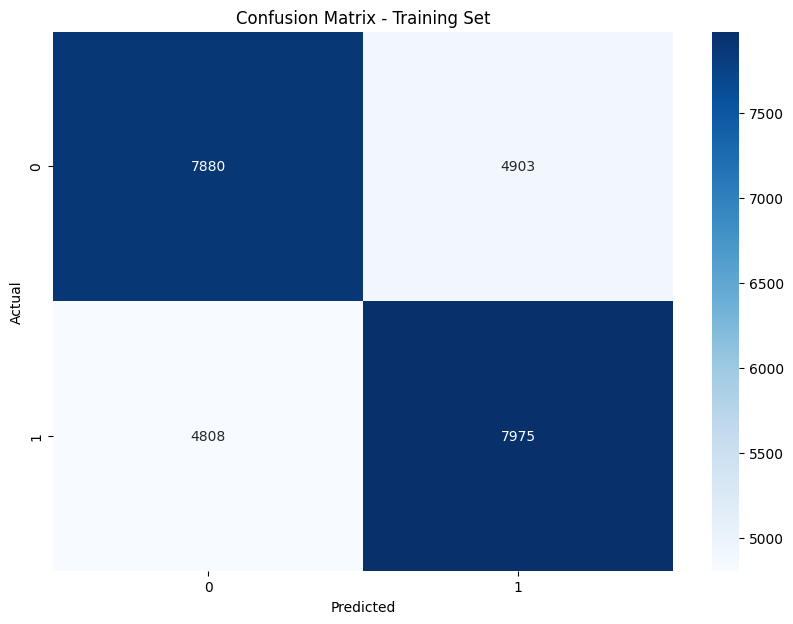

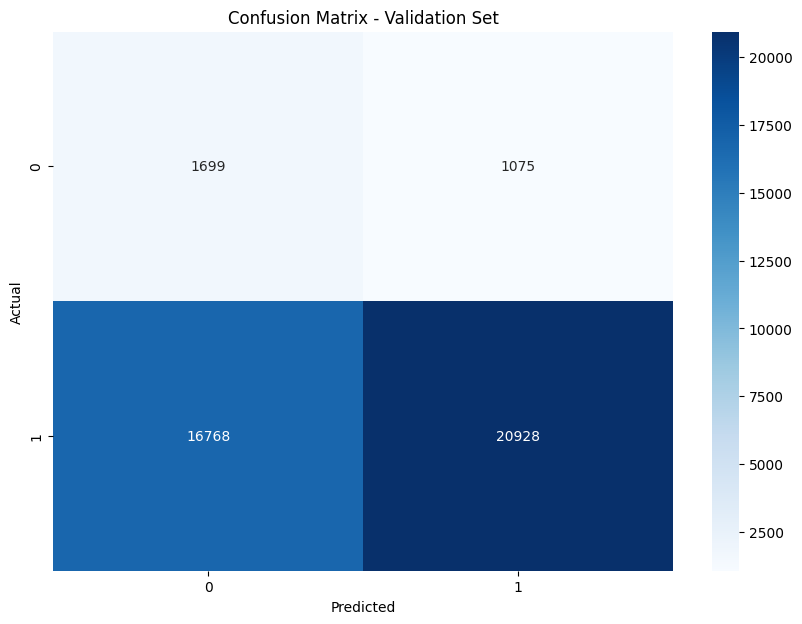

F1 Score (Train): 0.6215658002416118
F1 Score (Validation): 0.7011172716460912
Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.09      0.61      0.16      2774
           1       0.95      0.56      0.70     37696

    accuracy                           0.56     40470
   macro avg       0.52      0.58      0.43     40470
weighted avg       0.89      0.56      0.66     40470



In [192]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Predicciones y evaluación del modelo
y_train_pred = model.predict(X_train_resampled)
y_val_pred = model.predict(X_val)

# Matrices de confusión
train_cm = confusion_matrix(y_train_resampled, y_train_pred)
val_cm = confusion_matrix(y_val, y_val_pred)

# Función para graficar la matriz de confusión
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Graficar las matrices de confusión
plot_confusion_matrix(train_cm, 'Confusion Matrix - Training Set')
plot_confusion_matrix(val_cm, 'Confusion Matrix - Validation Set')

print(f"F1 Score (Train): {f1_score(y_train_resampled, y_train_pred)}")
print(f"F1 Score (Validation): {f1_score(y_val, y_val_pred)}")
print("Classification Report (Validation):")
print(classification_report(y_val, y_val_pred))

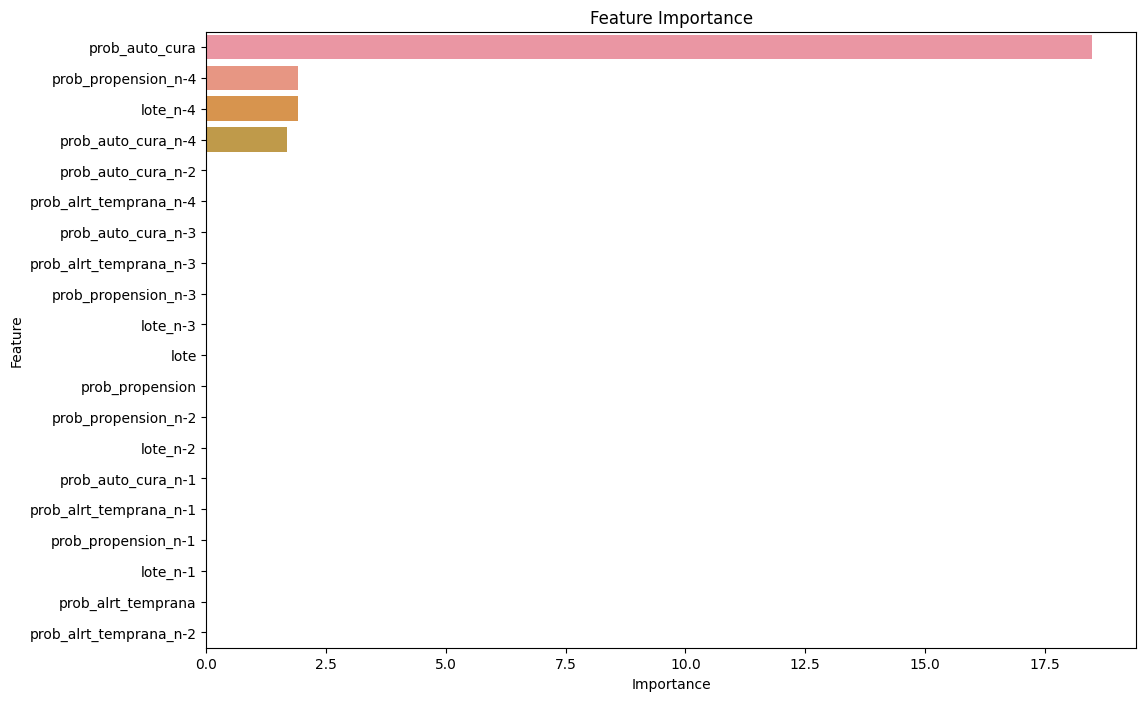

In [194]:
# Importancia de las características
feature_importances = model.get_feature_importance()
feature_importances_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Graficar la importancia de las características
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances_df.head(20).sort_values(by='Importance', ascending=False))
plt.title('Feature Importance')
plt.show()

### Iter 2

In [195]:
# Cargar los datos
df = muestra_train_val

# Definir las variables
features = ['lote'
,'prob_propension'
,'prob_alrt_temprana'
,'prob_auto_cura'
,'lote_n-1'
,'prob_propension_n-1'
,'prob_alrt_temprana_n-1'
,'prob_auto_cura_n-1'
,'lote_n-2'
,'prob_propension_n-2'
,'prob_alrt_temprana_n-2'
,'prob_auto_cura_n-2'
,'lote_n-3'
,'prob_propension_n-3'
,'prob_alrt_temprana_n-3'
,'prob_auto_cura_n-3'
,'lote_n-4'
,'prob_propension_n-4'
,'prob_alrt_temprana_n-4'
,'prob_auto_cura_n-4'
,'lote_n-5'
,'prob_propension_n-5'
,'prob_alrt_temprana_n-5'
,'prob_auto_cura_n-5'
,'lote_n-6'
,'prob_propension_n-6'
,'prob_alrt_temprana_n-6'
,'prob_auto_cura_n-6'
,'valor_cuota_mes'
,'pago_total'
,'porc_pago'
,'tiene_cuota_tdc'
,'tiene_cuota_libr_inv'
,'tiene_cuota_rot'
,'tiene_cuota_cart_ordinaria'
,'tiene_cuota_hipo'
,'tiene_cuota_libranza'
,'diferencia_dias'
,'marca_pago_mas'
,'marca_pago_menos'
,'marca_pago_igual'
,'marca_no_pago'
,'marca_facturacion_mes_sgte'
,'marca_cancelado'
,'marca_ajustes_banco'
,'ajustes_banco_no'
,'ajustes_banco_rediferidos'
,'ajustes_banco_ajustes'
,'valor_cuota_mes_n-1'
,'pago_total_n-1'
,'porc_pago_n-1'
,'diferencia_dias_n-1'
,'valor_cuota_mes_n-2'
,'pago_total_n-2'
,'porc_pago_n-2'
,'diferencia_dias_n-2'
,'valor_cuota_mes_n-3'
,'pago_total_n-3'
,'porc_pago_n-3'
,'diferencia_dias_n-3'
,'valor_cuota_mes_n-4'
,'pago_total_n-4'
,'porc_pago_n-4'
,'diferencia_dias_n-4'
,'valor_cuota_mes_n-5'
,'pago_total_n-5'
,'porc_pago_n-5'
,'diferencia_dias_n-5'
,'valor_cuota_mes_n-6'
,'pago_total_n-6'
,'porc_pago_n-6'
,'diferencia_dias_n-6'
]
target = 'var_rpta_alt'

# Crear conjuntos de entrenamiento y validación
train_df = df[df['fecha_corte'] < 202311]  # Ajusta la fecha según tus datos
val_df = df[df['fecha_corte'] >= 202311]  # Ajusta la fecha según tus datos

# Under-sampling de la clase mayoritaria en el conjunto de entrenamiento
df_majority = train_df[train_df[target] == 1]
df_minority = train_df[train_df[target] == 0]

df_majority_downsampled = resample(df_majority, 
                                   replace=False,    # sample without replacement
                                   n_samples=len(df_minority),     # to match minority class
                                   random_state=42)  # reproducible results

train_df_downsampled = pd.concat([df_majority_downsampled, df_minority])

# Separar características y objetivo
X_train = train_df_downsampled[features]
y_train = train_df_downsampled[target]
X_val = val_df[features]
y_val = val_df[target]

# Crear y entrenar el modelo CatBoost
model = CatBoostClassifier(random_seed=42, logging_level='Silent')
model.fit(X_train, y_train)

# Predicciones y evaluación del modelo
y_pred = model.predict(X_val)

print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

[[ 1698  1076]
 [14221 23475]]
              precision    recall  f1-score   support

           0       0.11      0.61      0.18      2774
           1       0.96      0.62      0.75     37696

    accuracy                           0.62     40470
   macro avg       0.53      0.62      0.47     40470
weighted avg       0.90      0.62      0.72     40470



In [196]:
# Cargar los datos
df 

# Definir las variables
features = features
target = 'var_rpta_alt'

# Crear conjuntos de entrenamiento y validación
train_df = df[df['fecha_corte'] < 202311]  # Ajusta la fecha según tus datos
val_df = df[df['fecha_corte'] >= 202311]  # Ajusta la fecha según tus datos

# Separar características y objetivo
X_train = train_df[features]
y_train = train_df[target]
X_val = val_df[features]
y_val = val_df[target]

# Under-sampling de la clase mayoritaria en el conjunto de entrenamiento
rus = RandomUnderSampler(sampling_strategy=1, random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

# Crear y entrenar el modelo CatBoost
model = CatBoostClassifier(random_seed=42, logging_level='Silent', eval_metric='F1')
model.fit(X_train_resampled, y_train_resampled, eval_set=(X_val, y_val), early_stopping_rounds=10)

# Predicciones y evaluación del modelo
y_pred = model.predict(X_val)

print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))
print(f"F1 Score: {f1_score(y_val, y_pred)}")

[[ 1699  1075]
 [16768 20928]]
              precision    recall  f1-score   support

           0       0.09      0.61      0.16      2774
           1       0.95      0.56      0.70     37696

    accuracy                           0.56     40470
   macro avg       0.52      0.58      0.43     40470
weighted avg       0.89      0.56      0.66     40470

F1 Score: 0.7011172716460912


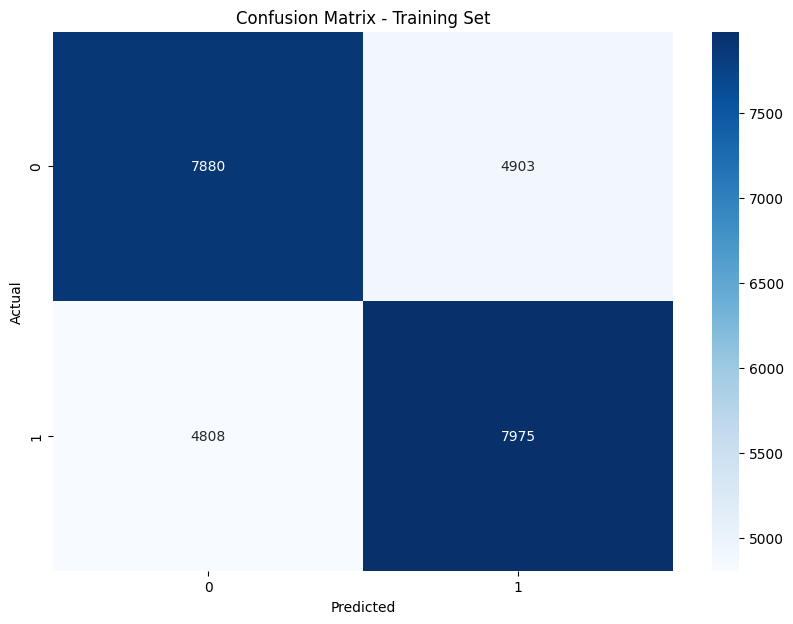

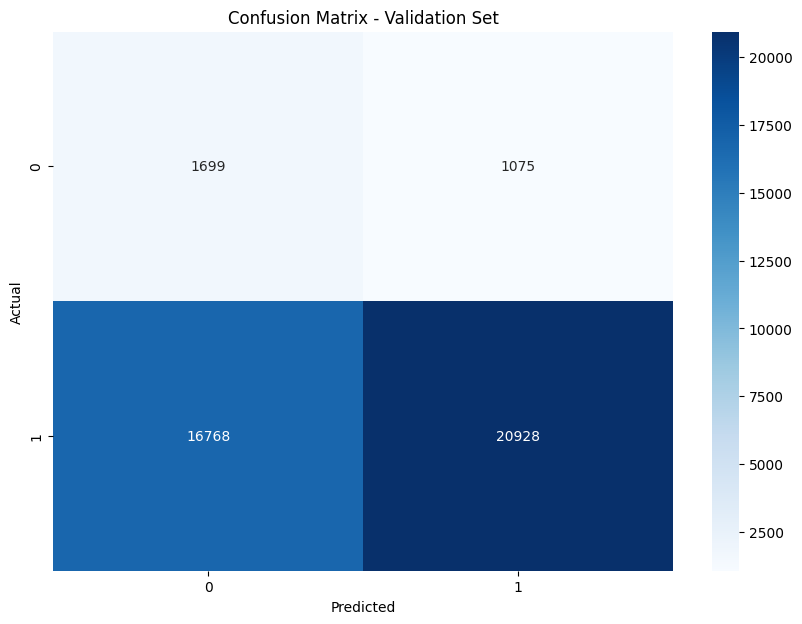

F1 Score (Train): 0.6215658002416118
F1 Score (Validation): 0.7011172716460912
Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.09      0.61      0.16      2774
           1       0.95      0.56      0.70     37696

    accuracy                           0.56     40470
   macro avg       0.52      0.58      0.43     40470
weighted avg       0.89      0.56      0.66     40470



In [197]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Predicciones y evaluación del modelo
y_train_pred = model.predict(X_train_resampled)
y_val_pred = model.predict(X_val)

# Matrices de confusión
train_cm = confusion_matrix(y_train_resampled, y_train_pred)
val_cm = confusion_matrix(y_val, y_val_pred)

# Función para graficar la matriz de confusión
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Graficar las matrices de confusión
plot_confusion_matrix(train_cm, 'Confusion Matrix - Training Set')
plot_confusion_matrix(val_cm, 'Confusion Matrix - Validation Set')

print(f"F1 Score (Train): {f1_score(y_train_resampled, y_train_pred)}")
print(f"F1 Score (Validation): {f1_score(y_val, y_val_pred)}")
print("Classification Report (Validation):")
print(classification_report(y_val, y_val_pred))

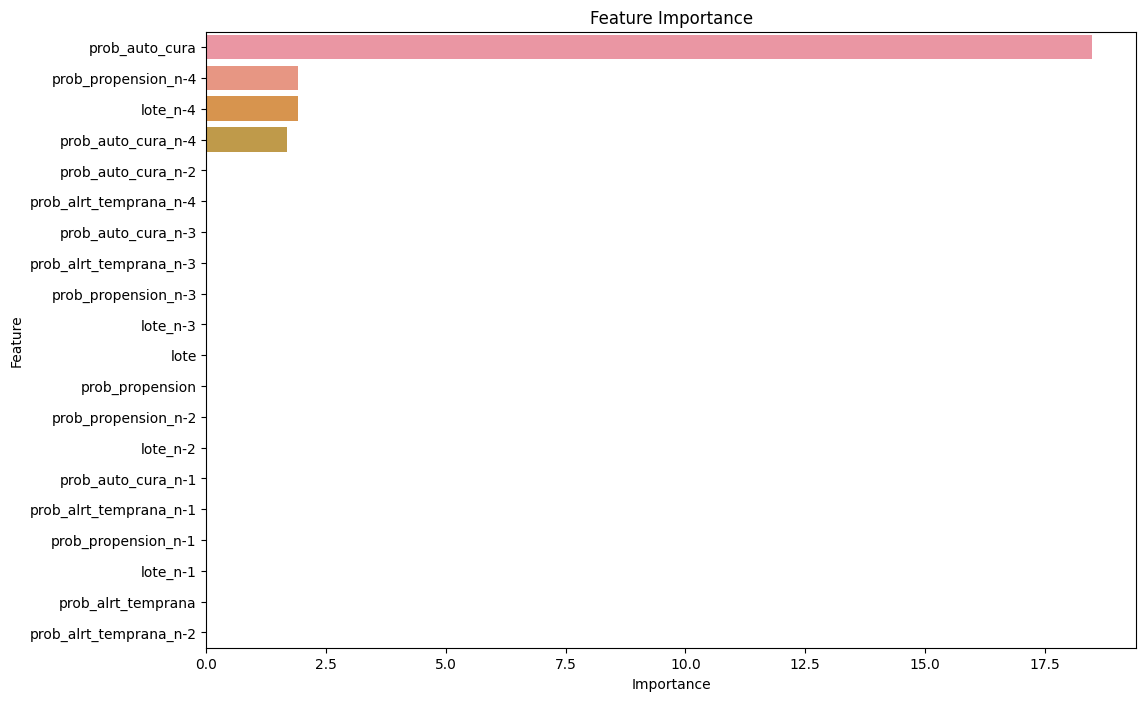

In [198]:
# Importancia de las características
feature_importances = model.get_feature_importance()
feature_importances_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Graficar la importancia de las características
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances_df.head(20).sort_values(by='Importance', ascending=False))
plt.title('Feature Importance')
plt.show()

In [201]:
feature_importances_df.sort_values(by='Importance', ascending=False)

,Feature,Importance
31,tiene_cuota_tdc,50.769327
3,prob_auto_cura,18.489074
56,valor_cuota_mes_n-3,8.170023
48,valor_cuota_mes_n-1,5.431550
28,valor_cuota_mes,4.068427
60,valor_cuota_mes_n-4,2.559597
68,valor_cuota_mes_n-6,2.034082
17,prob_propension_n-4,1.910227
16,lote_n-4,1.907544
19,prob_auto_cura_n-4,1.674237


### Iter 4

In [214]:
# Cargar los datos
df = muestra_train_val

# Definir las variables
features = [
'valor_cuota_mes_n-3'
,'valor_cuota_mes_n-1'
,'valor_cuota_mes'
,'valor_cuota_mes_n-4'
,'valor_cuota_mes_n-6'
,'prob_propension_n-4'
,'lote_n-4'
,'prob_auto_cura_n-4'
,'prob_alrt_temprana_n-6'
,'pago_total_n-1'
]
target = 'var_rpta_alt'

# Crear conjuntos de entrenamiento y validación
train_df = df[df['fecha_corte'] < 202311]  # Ajusta la fecha según tus datos
val_df = df[df['fecha_corte'] >= 202311]  # Ajusta la fecha según tus datos

# Under-sampling de la clase mayoritaria en el conjunto de entrenamiento
df_majority = train_df[train_df[target] == 1]
df_minority = train_df[train_df[target] == 0]

df_majority_downsampled = resample(df_majority, 
                                   replace=False,    # sample without replacement
                                   n_samples=len(df_minority),     # to match minority class
                                   random_state=42)  # reproducible results

train_df_downsampled = pd.concat([df_majority_downsampled, df_minority])

# Separar características y objetivo
X_train = train_df_downsampled[features]
y_train = train_df_downsampled[target]
X_val = val_df[features]
y_val = val_df[target]

# Crear y entrenar el modelo CatBoost
model = CatBoostClassifier(random_seed=42, logging_level='Silent')
model.fit(X_train, y_train)

# Predicciones y evaluación del modelo
y_pred = model.predict(X_val)

print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

[[ 1606  1168]
 [15534 22162]]
              precision    recall  f1-score   support

           0       0.09      0.58      0.16      2774
           1       0.95      0.59      0.73     37696

    accuracy                           0.59     40470
   macro avg       0.52      0.58      0.44     40470
weighted avg       0.89      0.59      0.69     40470



In [343]:
# Cargar los datos
df 

# Definir las variables
features = features
target = 'var_rpta_alt'

# Crear conjuntos de entrenamiento y validación
train_df = df[df['fecha_corte'] < 202311]  # Ajusta la fecha según tus datos
val_df = df[df['fecha_corte'] >= 202311]  # Ajusta la fecha según tus datos

# Separar características y objetivo
X_train = train_df[features]
y_train = train_df[target]
X_val = val_df[features]
y_val = val_df[target]

# Under-sampling de la clase mayoritaria en el conjunto de entrenamiento
rus = RandomUnderSampler(sampling_strategy=1, random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

# Crear y entrenar el modelo CatBoost
model = CatBoostClassifier(random_seed=42, logging_level='Silent', eval_metric='F1')
model.fit(X_train_resampled, y_train_resampled, eval_set=(X_val, y_val), early_stopping_rounds=10)

# Predicciones y evaluación del modelo
y_pred = model.predict(X_val)

print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))
print(f"F1 Score: {f1_score(y_val, y_pred)}")

[[ 1567  1207]
 [15845 21851]]
              precision    recall  f1-score   support

           0       0.09      0.56      0.16      2774
           1       0.95      0.58      0.72     37696

    accuracy                           0.58     40470
   macro avg       0.52      0.57      0.44     40470
weighted avg       0.89      0.58      0.68     40470

F1 Score: 0.7193271224939921


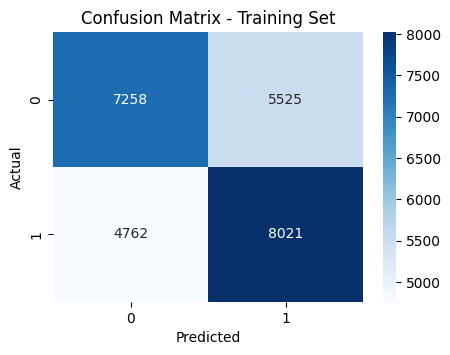

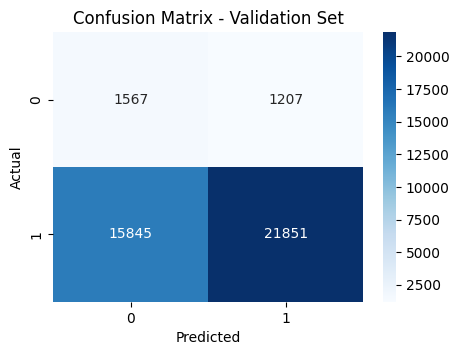

F1 Score (Train): 0.6092901363515515
F1 Score (Validation): 0.7193271224939921
Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.09      0.56      0.16      2774
           1       0.95      0.58      0.72     37696

    accuracy                           0.58     40470
   macro avg       0.52      0.57      0.44     40470
weighted avg       0.89      0.58      0.68     40470



In [344]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Predicciones y evaluación del modelo
y_train_pred = model.predict(X_train_resampled)
y_val_pred = model.predict(X_val)

# Matrices de confusión
train_cm = confusion_matrix(y_train_resampled, y_train_pred)
val_cm = confusion_matrix(y_val, y_val_pred)

# Función para graficar la matriz de confusión
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(5, 3.5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Graficar las matrices de confusión
plot_confusion_matrix(train_cm, 'Confusion Matrix - Training Set')
plot_confusion_matrix(val_cm, 'Confusion Matrix - Validation Set')

print(f"F1 Score (Train): {f1_score(y_train_resampled, y_train_pred)}")
print(f"F1 Score (Validation): {f1_score(y_val, y_val_pred)}")
print("Classification Report (Validation):")
print(classification_report(y_val, y_val_pred))

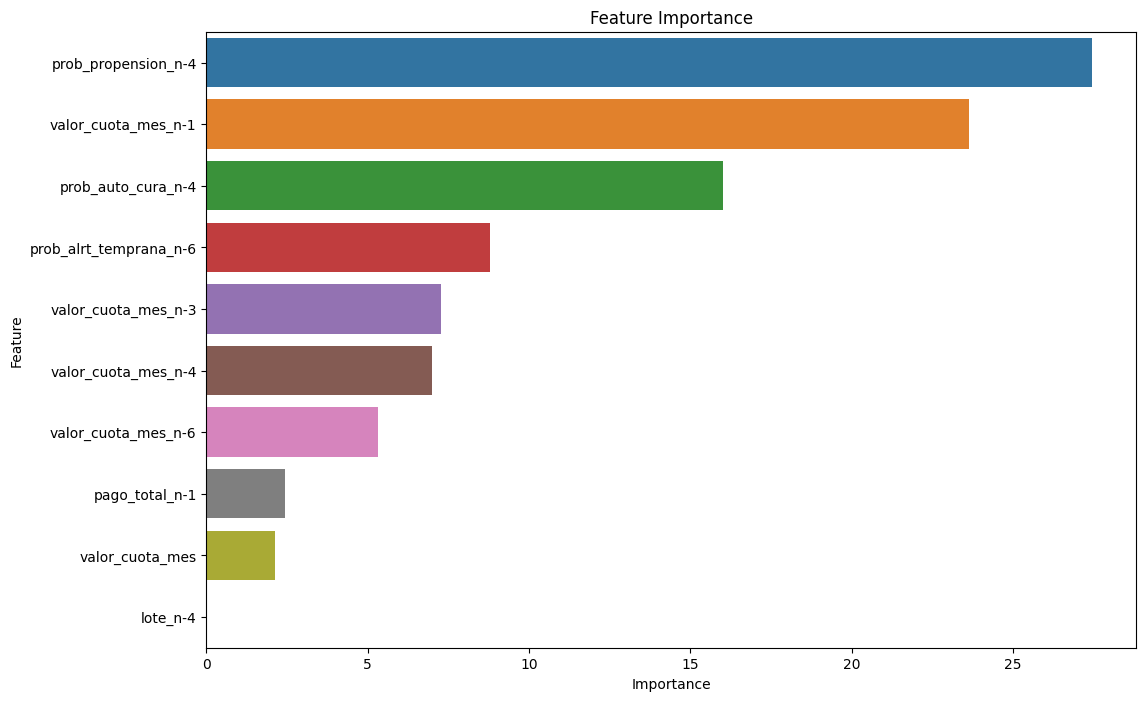

In [217]:
# Importancia de las características
feature_importances = model.get_feature_importance()
feature_importances_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Graficar la importancia de las características
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances_df.head(20).sort_values(by='Importance', ascending=False))
plt.title('Feature Importance')
plt.show()

In [218]:
feature_importances_df.sort_values(by='Importance', ascending=False)

,Feature,Importance
5,prob_propension_n-4,27.450535
1,valor_cuota_mes_n-1,23.626893
7,prob_auto_cura_n-4,16.019484
8,prob_alrt_temprana_n-6,8.777748
0,valor_cuota_mes_n-3,7.280066
3,valor_cuota_mes_n-4,6.976991
4,valor_cuota_mes_n-6,5.303757
9,pago_total_n-1,2.446279
2,valor_cuota_mes,2.118248
6,lote_n-4,0.000000


In [345]:
y_pred_train = predict(model, X_train)
y_pred_val = predict(model, X_val)
y_pred_test = predict(model, X_test)

# Consolidar los resultados
results = consolidate_results(y_train, y_val, y_test, y_pred_train, y_pred_val, y_pred_test, tecnica, model_name)  
            

# Guardar resultados
all_results = pd.concat([all_results, results], ignore_index=True)

## Exploración de Algoritmos y Tuneo

In [ ]:
muestra_train_val = base_modelado_df[base_modelado_df['fecha_corte'] != 202312]

In [281]:
muestra_train_val.to_csv('muestra_train_val.csv', index=False)

In [304]:
# Asegúrate de que la tabla esté ordenada por 'fecha_corte'
muestra_train_val = muestra_train_val.sort_values(by='fecha_corte')

# Calcular los índices para dividir el DataFrame
train_end = int(0.8 * len(muestra_train_val))
val_end = int(0.9 * len(muestra_train_val))

# Crear los conjuntos de entrenamiento, validación y prueba
train_set = muestra_train_val.iloc[:train_end]
val_set = muestra_train_val.iloc[train_end:val_end]
test_set = muestra_train_val.iloc[val_end:]

# Mostrar las primeras filas de cada conjunto para verificar el resultado
print("Train Set:")
print(train_set.shape)
print("\nValidation Set:")
print(val_set.shape)
print("\nTest Set:")
print(test_set.shape)

Train Set:
(187204, 76)

Validation Set:
(23400, 76)

Test Set:
(23401, 76)


In [287]:
# Cargar los datos
df = muestra_train_val

# Definir las variables
features = [
'valor_cuota_mes_n-3'
,'valor_cuota_mes_n-1'
,'valor_cuota_mes'
,'valor_cuota_mes_n-4'
,'valor_cuota_mes_n-6'
,'prob_propension_n-4'
,'lote_n-4'
,'prob_auto_cura_n-4'
,'prob_alrt_temprana_n-6'
,'pago_total_n-1'
]
target = 'var_rpta_alt'

In [334]:
# Calculo de metricas
print("Calculo de metricas")
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    return accuracy, precision, recall, f1, specificity, tn, fp, fn, tp

# def save_confusion_matrix(cm, title):
#     plt.figure(figsize=(5, 3.5))
#     sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
#     plt.title(title)
#     plt.xlabel('Predicted')
#     plt.ylabel('Actual')
#     cm_filename = '{title}.png'.format(title)
#     plt.savefig(cm_filename)
#     plt.close()
#     return cm_filename

# Optimizar modelo
def optimize_with_optuna_mlflow(X_train, y_train, X_val, y_val, X_test, y_test,
                                 n_trials=30, tecnica_submuestreo='None',
                                 experiment_name=None,model_type='catboost'):

    # Crear un nuevo experimento
    try:
        experiment_id = mlflow.create_experiment(experiment_name)
    except mlflow.exceptions.MlflowException as e:
        print(f"No se pudo crear el experimento. Error: {e}")
        experiment_id = mlflow.get_experiment_by_name(experiment_name).experiment_id
    
    # Establecer el experimento activo   
    mlflow.set_experiment(experiment_name)
    
    best_model = None
    best_score = 0

    def get_model_params(trial):
        if model_type == 'xgboost':
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 100, 500),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                'max_depth': trial.suggest_int('max_depth', 3, 10),
                'min_child_weight': trial.suggest_float('min_child_weight', 1, 10),
                'subsample': trial.suggest_float('subsample', 0.5, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
                'random_state': 42
            }
            return XGBClassifier(**params)
        
        elif model_type == 'lgbm':
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 100, 500),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                'num_leaves': trial.suggest_int('num_leaves', 31, 128),
                'min_child_samples': trial.suggest_int('min_child_samples', 20, 100),
                'subsample': trial.suggest_float('subsample', 0.5, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
                'is_unbalance':True,
                'random_state': 42
            }
            return LGBMClassifier(**params)
        
        elif model_type == 'catboost':
            params = {
                'iterations': trial.suggest_int('iterations', 100, 500),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                'depth': trial.suggest_int('depth', 4, 10),
                'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True),
                'border_count': trial.suggest_int('border_count', 200, 300),
                'random_strength': trial.suggest_float('random_strength', 1e-3, 10.0, log=True),
                'random_seed': 42,
                'auto_class_weights': 'Balanced'
            }
            return CatBoostClassifier(**params)
        elif model_type == 'rusboost':
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 100, 500),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                'random_state': 42
            }
            
            return RUSBoostClassifier(**params)
        
        else:
            raise ValueError("Model type not supported")

    def objective(trial):
        nonlocal best_model
        nonlocal best_score

        model = get_model_params(trial)

        if model_type == 'catboost':
            model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=100, verbose=False)
        elif model_type== 'xgboost':
            model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=100, verbose=False)
        elif model_type == 'lgbm':
            model.fit(X_train, y_train, eval_set=[(X_val, y_val)])
        else:
            model.fit(X_train, y_train)

        y_pred_train = model.predict(X_train) 
        accuracy_train, precision_train, recall_train, f1_train, specificity_train, tn_train, fp_train, fn_train, tp_train = calculate_metrics(y_train, y_pred_train)   

        y_pred_val = model.predict(X_val)
        accuracy, precision, recall, f1, specificity, tn, fp, fn, tp = calculate_metrics(y_val, y_pred_val)

        y_pred_test = model.predict(X_test)
        accuracy_test, precision_test, recall_test, f1_test, specificity_test, tn_test, fp_test, fn_test, tp_test = calculate_metrics(y_test, y_pred_test)
    

        if f1 > best_score:
            best_score = f1
            best_model = model

        # train_cm = confusion_matrix(y_train, y_pred_train)
        # val_cm = confusion_matrix(y_val, y_pred_val)
        # test_cm = confusion_matrix(y_test, y_pred_test)

        # cm_filename=save_confusion_matrix(val_cm, 'Confusion Matrix - Validation Set')


        with mlflow.start_run(experiment_id=experiment_id):
            mlflow.set_tag('tecnica_submuestreo', tecnica_submuestreo)
            mlflow.set_tag('model_type', model_type)

            mlflow.log_params(model.get_params())

            mlflow.log_metric('f1', f1)
            mlflow.log_metric('precision', precision)
            mlflow.log_metric('recall', recall)
            mlflow.log_metric('accuracy', accuracy)
            mlflow.log_metric('specificity', specificity)
            mlflow.log_metric('tn', tn)
            mlflow.log_metric('fp', fp)
            mlflow.log_metric('fn', fn)
            mlflow.log_metric('tp', tp)

            mlflow.log_metric('f1_test', f1_test)
            mlflow.log_metric('precision_test', precision_test)
            mlflow.log_metric('recall_test', recall_test)
            mlflow.log_metric('accuracy_test', accuracy_test)
            mlflow.log_metric('specificity_test', specificity_test)
            mlflow.log_metric('tn_test', tn_test)
            mlflow.log_metric('fp_test', fp_test)
            mlflow.log_metric('fn_test', fn_test)
            mlflow.log_metric('tp_test', tp_test)

            mlflow.log_metric('f1_train', f1_train)
            mlflow.log_metric('precision_train', precision_train)
            mlflow.log_metric('recall_train', recall_train)
            mlflow.log_metric('accuracy_train', accuracy_train)
            mlflow.log_metric('specificity_train', specificity_train)
            mlflow.log_metric('tn_train', tn_train)
            mlflow.log_metric('fp_train', fp_train)
            mlflow.log_metric('fn_train', fn_train)
            mlflow.log_metric('tp_train', tp_train)

            # mlflow.log_artifact(cm_filename)


            # Guardar el modelo como archivo .pkl con el nombre del experimento
            model_filename = f'{experiment_name}.pkl'
            with open(model_filename, 'wb') as f:
                pickle.dump(model, f)
            mlflow.log_artifact(model_filename)

        return f1

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials)

    print('Best hyperparameters: ', study.best_params)
    # optimal_threshold = study.best_params['threshold']

    # return best_model,optimal_threshold
    return best_model


# Tratamiento conjunto desbalanceado
print("Tratamiento conjunto desbalanceado")

def balance_data(X_train, y_train, tecnica_submuestreo):
    if tecnica_submuestreo == 'RandomUnderSampler':
        rus = RandomUnderSampler(sampling_strategy=1, random_state=42)
        X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)
    elif tecnica_submuestreo == 'tomeklinks':
        tomek_links = TomekLinks(sampling_strategy='majority') 
        X_train_resampled, y_train_resampled = tomek_links.fit_resample(X_train, y_train)
    else:
        raise ValueError(f"Metodo {tecnica_submuestreo} no soportada")
    return X_train_resampled, y_train_resampled


    
# Función para predecir
print("Predecir")
def predict(model, X, threshold=0.5):
    y_pred_proba = model.predict_proba(X)[:, 1]
    y_pred = (y_pred_proba > threshold).astype(int)
    return y_pred

# Función para consolidar resultados
print("Consolidar resultados")
def consolidate_results(y_train, y_val, y_test, y_pred_train, y_pred_val, y_pred_test, tecnica_submuestreo, model_name):
    results = {
        'tecnica_submuestreo': [tecnica_submuestreo] * 3,
        'tecnica_ml': [model_name] * 3,
        'dataset': ['Train', 'Validation', 'Test'],
        'accuracy': [accuracy_score(y_train, y_pred_train), accuracy_score(y_val, y_pred_val), accuracy_score(y_test, y_pred_test)],
        'precision': [precision_score(y_train, y_pred_train), precision_score(y_val, y_pred_val), precision_score(y_test, y_pred_test)],
        'recall': [recall_score(y_train, y_pred_train), recall_score(y_val, y_pred_val), recall_score(y_test, y_pred_test)],
        'specificity': [
            calculate_metrics(y_train, y_pred_train)[4],
            calculate_metrics(y_val, y_pred_val)[4],
            calculate_metrics(y_test, y_pred_test)[4]
        ],
        'f1_score': [f1_score(y_train, y_pred_train), f1_score(y_val, y_pred_val), f1_score(y_test, y_pred_test)],
        'tn': [calculate_metrics(y_train, y_pred_train)[5], calculate_metrics(y_val, y_pred_val)[5], calculate_metrics(y_test, y_pred_test)[5]],
        'fp': [calculate_metrics(y_train, y_pred_train)[6], calculate_metrics(y_val, y_pred_val)[6], calculate_metrics(y_test, y_pred_test)[6]],
        'fn': [calculate_metrics(y_train, y_pred_train)[7], calculate_metrics(y_val, y_pred_val)[7], calculate_metrics(y_test, y_pred_test)[7]],
        'tp': [calculate_metrics(y_train, y_pred_train)[8], calculate_metrics(y_val, y_pred_val)[8], calculate_metrics(y_test, y_pred_test)[8]]
    }
    return pd.DataFrame(results)



Calculo de metricas
Tratamiento conjunto desbalanceado
Predecir
Consolidar resultados


In [341]:
model_name='xgboost_Cla_optuna_v2'
model_type='xgboost'
all_results = pd.DataFrame()
all_sets = {}
features = [
'valor_cuota_mes_n-3'
,'valor_cuota_mes_n-1'
,'valor_cuota_mes'
,'valor_cuota_mes_n-4'
,'valor_cuota_mes_n-6'
,'prob_propension_n-4'
,'lote_n-4'
,'prob_auto_cura_n-4'
,'prob_alrt_temprana_n-6'
,'pago_total_n-1'
]
target = 'var_rpta_alt'

tecnicas_submuestreo=['RandomUnderSampler']

for tecnica in tecnicas_submuestreo:

    print(f"Se va a entrenar el modelo con la técnica de: {tecnica} para {model_name}")

    # Obtener base de entrenamiento
    X_train= train_set[features]
    y_train= train_set[target]

    X_val = val_set[features]
    y_val = val_set[target]

    X_test = test_set[features]
    y_test = test_set[target]

    # Balancear el conjunto de entrenamiento

    rus = RandomUnderSampler(sampling_strategy=1, random_state=42)
    X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

    print(y_train_resampled.value_counts())

    # Optimizar el modelo
    experiment_name_ = f"{model_name}_{tecnica}"
    print(f"Nombre del experimento: { experiment_name_}")
    model= optimize_with_optuna_mlflow(X_train_resampled, y_train_resampled, X_val, y_val, X_test, y_test,
                                                           n_trials=100, tecnica_submuestreo=tecnica, 
                                                           experiment_name=experiment_name_,
                                                           model_type=model_type) 
    
    y_pred_train = predict(model, X_train)
    y_pred_val = predict(model, X_val)
    y_pred_test = predict(model, X_test)

    # Consolidar los resultados
    results = consolidate_results(y_train, y_val, y_test, y_pred_train, y_pred_val, y_pred_test, tecnica, model_name)  
                

    # Guardar resultados
    all_results = pd.concat([all_results, results], ignore_index=True)
    all_results.to_csv('all_results_v4.csv', index=False)
    


[I 2024-08-04 17:46:48,711] A new study created in memory with name: no-name-ff309207-0f0a-4837-a0e6-4caf5cf85f2a


Se va a entrenar el modelo con la técnica de: RandomUnderSampler para xgboost_Cla_optuna_v2
0    12285
1    12285
Name: var_rpta_alt, dtype: int64
Nombre del experimento: xgboost_Cla_optuna_v2_RandomUnderSampler


c:\Users\davzapat\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-08-04 17:46:49,713] Trial 0 finished with value: 0.7367504074636093 and parameters: {'n_estimators': 471, 'learning_rate': 0.10253057712122612, 'max_depth': 5, 'min_child_weight': 4.882273245561278, 'subsample': 0.9009211066116063, 'colsample_bytree': 0.8240448806307878}. Best is trial 0 with value: 0.7367504074636093.
c:\Users\davzapat\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-08-04 17:46:50,589] Trial 1 finished with value: 0.7300412452680942 and par

Best hyperparameters:  {'n_estimators': 349, 'learning_rate': 0.23115146053797855, 'max_depth': 7, 'min_child_weight': 2.2507747792558517, 'subsample': 0.8418321517821378, 'colsample_bytree': 0.7776416262507592}


In [342]:
all_results

,tecnica_submuestreo,tecnica_ml,dataset,accuracy,precision,recall,specificity,f1_score,tn,fp,fn,tp
0,RandomUnderSampler,xgboost_Cla_optuna_v2,Train,0.656535,0.958533,0.661009,0.592837,0.782442,7283,5002,59296,115623
1,RandomUnderSampler,xgboost_Cla_optuna_v2,Validation,0.626752,0.947318,0.633853,0.532602,0.759513,874,767,7967,13792
2,RandomUnderSampler,xgboost_Cla_optuna_v2,Test,0.618563,0.945663,0.625953,0.519926,0.753289,848,783,8143,13627


## Construcción de tabla de Punteo

In [252]:
df_ids_oot = pd.read_csv('prueba_op_base_pivot_var_rpta_alt_enmascarado_oot.csv')
df_ids_oot["llave_modelo"] = df_ids_oot["nit_enmascarado"].astype(str) + \
                                                    "#" + df_ids_oot["num_oblig_orig_enmascarado"].astype(str) + \
                                                    "#" + df_ids_oot["num_oblig_enmascarado"].astype(str)
df_ids_oot["llave_modelo_2"] = df_ids_oot["nit_enmascarado"].astype(str) + \
                                                    "#" + df_ids_oot["num_oblig_enmascarado"].astype(str)
df_ids_oot["fecha_corte"] = 202312


df_ids_oot.head()

,nit_enmascarado,num_oblig_orig_enmascarado,num_oblig_enmascarado,fecha_var_rpta_alt,llave_modelo,llave_modelo_2,fecha_corte
0,257335,444821,635511,202401,257335#444821#635511,257335#635511,202312
1,59584,350400,730364,202401,59584#350400#730364,59584#730364,202312
2,397604,973821,106521,202401,397604#973821#106521,397604#106521,202312
3,368086,382995,696856,202401,368086#382995#696856,368086#696856,202312
4,255009,434238,645924,202401,255009#434238#645924,255009#645924,202312


In [253]:
merged_df_v1= pd.merge(df_ids_oot, 
                     df_var_prob_mod_cobranza_v1, 
                     left_on=['llave_modelo_2', 'fecha_corte'], 
                     right_on=['llave_modelo_2', 'fecha_corte'], 
                     how='left')  # Puedes cambiar el tipo de unión a 'left', 'right' o 'outer' si es necesario

# Mostrar las primeras filas del DataFrame resultante
merged_df_v1.head()

,nit_enmascarado,num_oblig_orig_enmascarado,num_oblig_enmascarado,fecha_var_rpta_alt,llave_modelo,llave_modelo_2,fecha_corte,lote,prob_propension,prob_alrt_temprana,prob_auto_cura,lote_n-1,prob_propension_n-1,prob_alrt_temprana_n-1,prob_auto_cura_n-1,lote_n-2,prob_propension_n-2,prob_alrt_temprana_n-2,prob_auto_cura_n-2,lote_n-3,prob_propension_n-3,prob_alrt_temprana_n-3,prob_auto_cura_n-3,lote_n-4,prob_propension_n-4,prob_alrt_temprana_n-4,prob_auto_cura_n-4,lote_n-5,prob_propension_n-5,prob_alrt_temprana_n-5,prob_auto_cura_n-5,lote_n-6,prob_propension_n-6,prob_alrt_temprana_n-6,prob_auto_cura_n-6
0,257335,444821,635511,202401,257335#444821#635511,257335#635511,202312,1.0,0.733536,0.424859,0.697358,1.0,0.749842,0.446730,0.651623,1.0,0.834370,0.439881,0.641469,1.0,0.832870,0.305179,0.763604,1.0,0.834330,0.327832,0.771047,1.0,0.790664,0.466034,0.545282,1.0,0.780205,0.361285,0.689167
1,59584,350400,730364,202401,59584#350400#730364,59584#730364,202312,2.0,0.741083,0.203964,0.787728,2.0,0.764593,0.102070,0.805125,2.0,0.771283,0.101698,0.804369,2.0,0.784670,0.123735,0.812374,2.0,0.777586,0.154385,0.794606,2.0,0.820647,0.125408,0.827273,2.0,0.791695,0.125364,0.729285
2,397604,973821,106521,202401,397604#973821#106521,397604#106521,202312,1.0,0.250561,0.715489,0.313812,1.0,0.359754,0.714111,0.189609,1.0,0.619115,0.675994,0.304139,1.0,0.814228,0.538298,0.376212,1.0,0.800426,0.319392,0.845383,1.0,0.841541,0.106415,0.812327,1.0,0.839025,0.122032,0.803535
3,368086,382995,696856,202401,368086#382995#696856,368086#696856,202312,1.0,0.742705,0.491246,0.372921,1.0,0.725986,0.473788,0.302219,1.0,0.660659,0.512603,0.225186,1.0,0.738193,0.441936,0.337765,2.0,0.788748,0.366539,0.597241,1.0,0.839129,0.238351,0.860538,2.0,0.805095,0.342535,0.872748
4,255009,434238,645924,202401,255009#434238#645924,255009#645924,202312,3.0,0.291181,0.597897,0.299553,3.0,0.147081,0.592523,0.163301,3.0,0.136202,0.586170,0.175528,3.0,0.249834,0.586170,0.147350,3.0,0.290205,0.584584,0.113752,3.0,0.395668,0.594532,0.215063,3.0,0.292125,0.588536,0.153101


In [257]:
merged_df_v2_punteo= pd.merge(merged_df_v1, 
                     df_comportamieto_pagos, 
                     left_on=['llave_modelo_2', 'fecha_corte'], 
                     right_on=['llave_modelo_2', 'fecha_corte'], 
                     how='left')  # Puedes cambiar el tipo de unión a 'left', 'right' o 'outer' si es necesario

# Mostrar las primeras filas del DataFrame resultante
merged_df_v2_punteo.head()

,nit_enmascarado,num_oblig_orig_enmascarado,num_oblig_enmascarado,fecha_var_rpta_alt,llave_modelo,llave_modelo_2,fecha_corte,lote,prob_propension,prob_alrt_temprana,prob_auto_cura,lote_n-1,prob_propension_n-1,prob_alrt_temprana_n-1,prob_auto_cura_n-1,lote_n-2,prob_propension_n-2,prob_alrt_temprana_n-2,prob_auto_cura_n-2,lote_n-3,prob_propension_n-3,prob_alrt_temprana_n-3,prob_auto_cura_n-3,lote_n-4,prob_propension_n-4,prob_alrt_temprana_n-4,prob_auto_cura_n-4,lote_n-5,prob_propension_n-5,prob_alrt_temprana_n-5,prob_auto_cura_n-5,lote_n-6,prob_propension_n-6,prob_alrt_temprana_n-6,prob_auto_cura_n-6,valor_cuota_mes,pago_total,porc_pago,tiene_cuota_tdc,tiene_cuota_libr_inv,tiene_cuota_rot,tiene_cuota_cart_ordinaria,tiene_cuota_hipo,tiene_cuota_libranza,diferencia_dias,marca_pago_mas,marca_pago_menos,marca_pago_igual,marca_no_pago,marca_facturacion_mes_sgte,marca_cancelado,marca_ajustes_banco,ajustes_banco_no,ajustes_banco_rediferidos,ajustes_banco_ajustes,valor_cuota_mes_n-1,pago_total_n-1,porc_pago_n-1,diferencia_dias_n-1,valor_cuota_mes_n-2,pago_total_n-2,porc_pago_n-2,diferencia_dias_n-2,valor_cuota_mes_n-3,pago_total_n-3,porc_pago_n-3,diferencia_dias_n-3,valor_cuota_mes_n-4,pago_total_n-4,porc_pago_n-4,diferencia_dias_n-4,valor_cuota_mes_n-5,pago_total_n-5,porc_pago_n-5,diferencia_dias_n-5,valor_cuota_mes_n-6,pago_total_n-6,porc_pago_n-6,diferencia_dias_n-6
0,257335,444821,635511,202401,257335#444821#635511,257335#635511,202312,1.0,0.733536,0.424859,0.697358,1.0,0.749842,0.446730,0.651623,1.0,0.834370,0.439881,0.641469,1.0,0.832870,0.305179,0.763604,1.0,0.834330,0.327832,0.771047,1.0,0.790664,0.466034,0.545282,1.0,0.780205,0.361285,0.689167,158905.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1058587.0,0.0,0.0,0.0,682842.0,2731369.0,400.0,4.0,710991.0,0.0,0.0,0.0,670795.0,1341590.0,200.0,0.0,614989.0,1229978.0,200.0,0.0,763353.0,0.0,0.0,0.0
1,59584,350400,730364,202401,59584#350400#730364,59584#730364,202312,2.0,0.741083,0.203964,0.787728,2.0,0.764593,0.102070,0.805125,2.0,0.771283,0.101698,0.804369,2.0,0.784670,0.123735,0.812374,2.0,0.777586,0.154385,0.794606,2.0,0.820647,0.125408,0.827273,2.0,0.791695,0.125364,0.729285,529061.0,40243.0,8.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,441917.0,0.0,0.0,0.0,376534.0,1129604.0,300.0,0.0,405397.0,1216192.0,300.0,0.0,375490.0,750980.0,200.0,0.0,382420.0,1147261.0,300.0,0.0,243747.0,974990.0,400.0,2.0
2,397604,973821,106521,202401,397604#973821#106521,397604#106521,202312,1.0,0.250561,0.715489,0.313812,1.0,0.359754,0.714111,0.189609,1.0,0.619115,0.675994,0.304139,1.0,0.814228,0.538298,0.376212,1.0,0.800426,0.319392,0.845383,1.0,0.841541,0.106415,0.812327,1.0,0.839025,0.122032,0.803535,2040349.0,1000000.0,49.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2022944.0,0.0,0.0,0.0,1440680.0,84010.0,6.0,0.0,578181.0,0.0,0.0,0.0,365267.0,400027.0,110.0,0.0,376643.0,352000.0,93.0,0.0,364762.0,364762.0,100.0,0.0
3,368086,382995,696856,202401,368086#382995#696856,368086#696856,202312,1.0,0.742705,0.491246,0.372921,1.0,0.725986,0.473788,0.302219,1.0,0.660659,0.512603,0.225186,1.0,0.738193,0.441936,0.337765,2.0,0.788748,0.366539,0.597241,1.0,0.839129,0.238351,0.860538,2.0,0.805095,0.342535,0.872748,265565.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,193784.0,0.0,0.0,0.0,141993.0,7651.0,5.0,0.0,305660.0,615063.0,201.0,0.0,171188.0,93055.0,54.0,0.0,170745.0,337280.0,198.0,0.0,427475.0,34597.0,8.0,15.0
4,255009,434238,645924,202401,255009#434238#645924,255009#645924,202312,3.0,0.291181,0.597897,0.299553,3.0,0.147081,0.592523,0.163301,3.0,0.136202,0.586170,0.175528,3.0,0.249834,0.586170,0.147350,3.0,0.290205,0.584584,0.113752,3.0,0.395668,0.594532,0.215063,3.0,0.292125,0.588536,0.153101,48022.0,242801.0,506.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,215613.0,0.0,0.0,0.0,167598.0,0.0,0.0,0.0,118191.0,0.0,0.0,0.0,69683.0,0.0,0.0,0.0,204650.0,183817.0,90.0,0.0,153

In [259]:
base_punteo_df= merged_df_v2_punteo[[
'llave_modelo'
,'llave_modelo_2'
,'fecha_var_rpta_alt'

, 'valor_cuota_mes_n-3'
,'valor_cuota_mes_n-1'
,'valor_cuota_mes'
,'valor_cuota_mes_n-4'
,'valor_cuota_mes_n-6'
,'prob_propension_n-4'
,'lote_n-4'
,'prob_auto_cura_n-4'
,'prob_alrt_temprana_n-6'
,'pago_total_n-1'
]]

base_punteo_df.head()

,llave_modelo,llave_modelo_2,fecha_var_rpta_alt,valor_cuota_mes_n-3,valor_cuota_mes_n-1,valor_cuota_mes,valor_cuota_mes_n-4,valor_cuota_mes_n-6,prob_propension_n-4,lote_n-4,prob_auto_cura_n-4,prob_alrt_temprana_n-6,pago_total_n-1
0,257335#444821#635511,257335#635511,202401,710991.0,1058587.0,158905.0,670795.0,763353.0,0.834330,1.0,0.771047,0.361285,0.0
1,59584#350400#730364,59584#730364,202401,405397.0,441917.0,529061.0,375490.0,243747.0,0.777586,2.0,0.794606,0.125364,0.0
2,397604#973821#106521,397604#106521,202401,578181.0,2022944.0,2040349.0,365267.0,364762.0,0.800426,1.0,0.845383,0.122032,0.0
3,368086#382995#696856,368086#696856,202401,305660.0,193784.0,265565.0,171188.0,427475.0,0.788748,2.0,0.597241,0.342535,0.0
4,255009#434238#645924,255009#645924,202401,118191.0,215613.0,48022.0,69683.0,153883.0,0.290205,3.0,0.113752,0.588536,0.0


In [260]:
base_punteo_df=base_punteo_df.fillna(0)

In [261]:
X_oot = base_punteo_df[[ 'valor_cuota_mes_n-3'
,'valor_cuota_mes_n-1'
,'valor_cuota_mes'
,'valor_cuota_mes_n-4'
,'valor_cuota_mes_n-6'
,'prob_propension_n-4'
,'lote_n-4'
,'prob_auto_cura_n-4'
,'prob_alrt_temprana_n-6'
,'pago_total_n-1']]

In [262]:
y_oot= model.predict(X_oot)

In [266]:
X_oot.shape

(112549, 10)

In [264]:
y_oot.shape

(112549,)

In [263]:
oot_ids = base_punteo_df[['llave_modelo']]
oot_ids['var_rpta_alt'] = y_oot
oot_ids.head()


C:\Users\davzapat\AppData\Local\Temp\ipykernel_30912\1640268760.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oot_ids['var_rpta_alt'] = y_oot


,llave_modelo,var_rpta_alt
0,257335#444821#635511,0
1,59584#350400#730364,1
2,397604#973821#106521,0
3,368086#382995#696856,1
4,255009#434238#645924,1


In [267]:
oot_ids = oot_ids.rename(columns={'llave_modelo': 'ID'})

In [269]:
oot_ids.to_csv('oot_ids.csv', index=False)

In [268]:
# Tomar una muestra aleatoria del 30% del DataFrame
oot_ids_sample = oot_ids.sample(frac=0.3, random_state=42)

# Guardar la muestra en un archivo CSV
oot_ids_sample.to_csv('oot_ids_sample.csv', index=False)

# Mostrar las primeras filas del DataFrame de muestra para verificar el resultado
oot_ids_sample.head()

,ID,var_rpta_alt
97502,117150#101916#985855,1
46091,157733#282808#800242,1
54839,365811#41991#1063112,1
36703,254293#724443#355899,0
30004,583141#630694#449648,1
